In this notebook we will implement a [Duelling](https://arxiv.org/pdf/1511.06581.pdf) [Double](https://arxiv.org/pdf/1509.06461.pdf) [DQN](https://arxiv.org/pdf/1312.5602.pdf) Agent with a [Prioritized Replay Buffer](https://arxiv.org/abs/1511.05952) and n-step bootstrap. 

We will assume our observations to be arrays of shape (batch_size, height, width, channels). For the flatland environment, this can be an image of the current environment grid or the transition maps. We will first using just a picture of the environment grid as our pbservation for training a single agent. 

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

# A Sample picture of environment grid to be used as observation

In [2]:
from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv, GlobalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

In [3]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1
width = 20
height = 20
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=env_seed)
env = RailEnv(width = width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=GlobalObs)
env.reset()

env_renderer = RenderTool(env)

In [4]:
obs, info = env.reset()

In [5]:
env_renderer.render_env(show=False)

/home/prarit/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/flatland/utils/rendertools.py:396: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


In [6]:
env_image = env_renderer.get_image()
env_image.shape

(464, 464, 4)

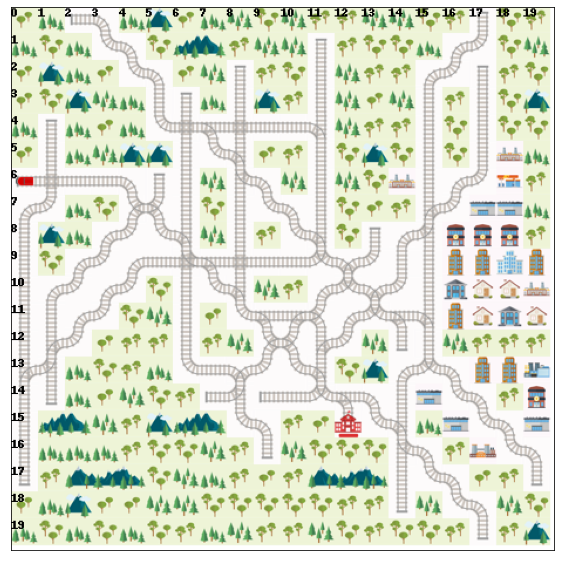

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(env_image)
plt.xticks([])
plt.yticks([])
plt.show()

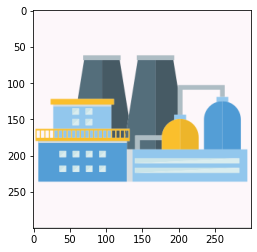

In [8]:
imm = env_renderer.gl.lBuildings
plt.imshow(imm[11])

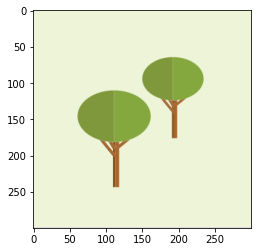

In [9]:
imm = env_renderer.gl.scenery
plt.imshow(imm[1])

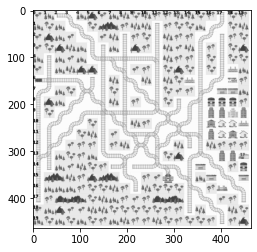

In [10]:
# gray scale image of the env
bw_image = np.mean(env_image, axis = 2)
plt.imshow(bw_image, cmap = 'gray')
plt.show()

In [11]:
obs[0][0][0,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

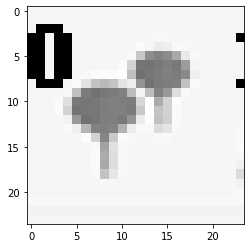

In [12]:
# gray scale image of the first cell (top-left corner) of the grid
bw_image = np.mean(env_image, axis = 2)
plt.imshow(bw_image[:24,:24], cmap = 'gray')
plt.show()

In [13]:
# destination cell
np.argwhere(obs[0][2][:,:,0]!=0)

array([[15, 12]])

In [14]:
obs[0][0][15,12]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

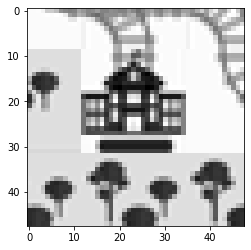

In [15]:
# gray scale image of the cell containing the destination
r = 15*24
c = 12*24
plt.imshow(bw_image[r-24:r+24,c-24:c+24], cmap = 'gray')
plt.show()

# The Duelling DQN Architecture

In [16]:
def NormalizedConvLayer(in_channels, out_channels, kernel_size, padding = 0, stride = 1, batch_norm = True):
    """
    Returns Convolutional Layer with batch-norm 
    """
    bias = not batch_norm
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = bias)
    layers.append(conv)
    if batch_norm:
        norm = nn.BatchNorm2d(out_channels)
        layers.append(norm)
    
    return nn.Sequential(*layers)   

In [17]:
class DuellingDQN(nn.Module):
    def __init__(self, in_channels, conv_dim = 32, kernel_size = 6, num_outputs = 5):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.conv_dim = conv_dim
        self.kernel_size = kernel_size
        self.num_outputs = num_outputs
        
        # input is an image a 464 x 464 image
        
        self.conv1 = NormalizedConvLayer(in_channels, conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 32 x 116 x 116   
        
        self.conv2 = NormalizedConvLayer(conv_dim, 2*conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 64 x 29 x 29 
        
        self.conv3 = NormalizedConvLayer(2*conv_dim, 4*conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 128  x 7 x 7 
        
        self.conv4 = NormalizedConvLayer(4*conv_dim, 8*conv_dim, kernel_size = 4, stride = 2, padding = 1)
        # default output shape = 256 x 3 x 3 
        
        self.conv5 = NormalizedConvLayer(8*conv_dim, 16*conv_dim, kernel_size = 3)
        # default output shape = 512 x 1 x 1 
        
        self.value_in = nn.Linear(in_features = 16*conv_dim, out_features = 8*conv_dim, bias = False)
        self.BatchNormV = nn.BatchNorm1d(num_features = 8*conv_dim)
        self.value_out = nn.Linear(in_features = 8*conv_dim, out_features = 1)
        
        self.advantage_in = nn.Linear(in_features = 16*conv_dim, out_features = 8*conv_dim, bias = False)
        self.BatchNormA = nn.BatchNorm1d(num_features = 8*conv_dim)
        self.advantage_out = nn.Linear(in_features = 8*conv_dim, out_features = num_outputs)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        # print(x.shape)
        x = F.selu(self.conv1(x))
        # print(x.shape)
        x = F.selu(self.conv2(x))
        # print(x.shape)
        x = F.selu(self.conv3(x))
        # print(x.shape)
        x = F.selu(self.conv4(x))
        # print(x.shape)
        x = F.selu(self.conv5(x))
        # print(x.shape)
        
        assert x.shape == (batch_size, 16*self.conv_dim, 1, 1), \
        "Wrong shape of conv5 output. Expected {}, got {}".format((batch_size, 16*self.conv_dim, 1, 1), x.size())
        
        x = x.view(batch_size, -1)
        # print(x.shape)
        
        v = F.selu(self.BatchNormV(self.value_in(x)))
        v = self.value_out(v)
        # print(v.shape)
        
        a = F.selu(self.BatchNormA(self.advantage_in(x)))
        a = self.advantage_out(a)
        # print(a.shape)
        
        mn = a.mean(dim = 1, keepdim = True)
        # print(mn.shape)
        
        return v + (a - mn)   
    
    
    def __repr__(self):
        return "DuellingDQN(in_channels = {}, conv_dim = {},"\
    " kernel_size = {}, num_outputs = {})".format(self.in_channels, self.conv_dim, self.kernel_size, self.num_outputs)

In [18]:
# testing 
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 6)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 6, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


In [19]:
# kernel_size between 4 and 9 (inclusive) are allowed and do not trigger an any errors
# With other kernel size, some of the assumptions made in the design of conv4 and conv5 get violated
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 4)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 4, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


In [20]:
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 9)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 9, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


### The errors in the following code cells are intentional

In [21]:
# error with kernel_size = 3
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 3)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 3, num_outputs = 5)
torch.Size([32, 4, 464, 464])


AssertionError: Wrong shape of conv5 output. Expected (32, 512, 1, 1), got torch.Size([32, 512, 2, 2])

In [ ]:
# error with kernel_size = 10
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 10)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)